<a href="https://colab.research.google.com/github/karans17s/Practical_Implementation_Of_Deep_learning/blob/main/PHASE_7_MACHINE_TRANSLATION_SpaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation:

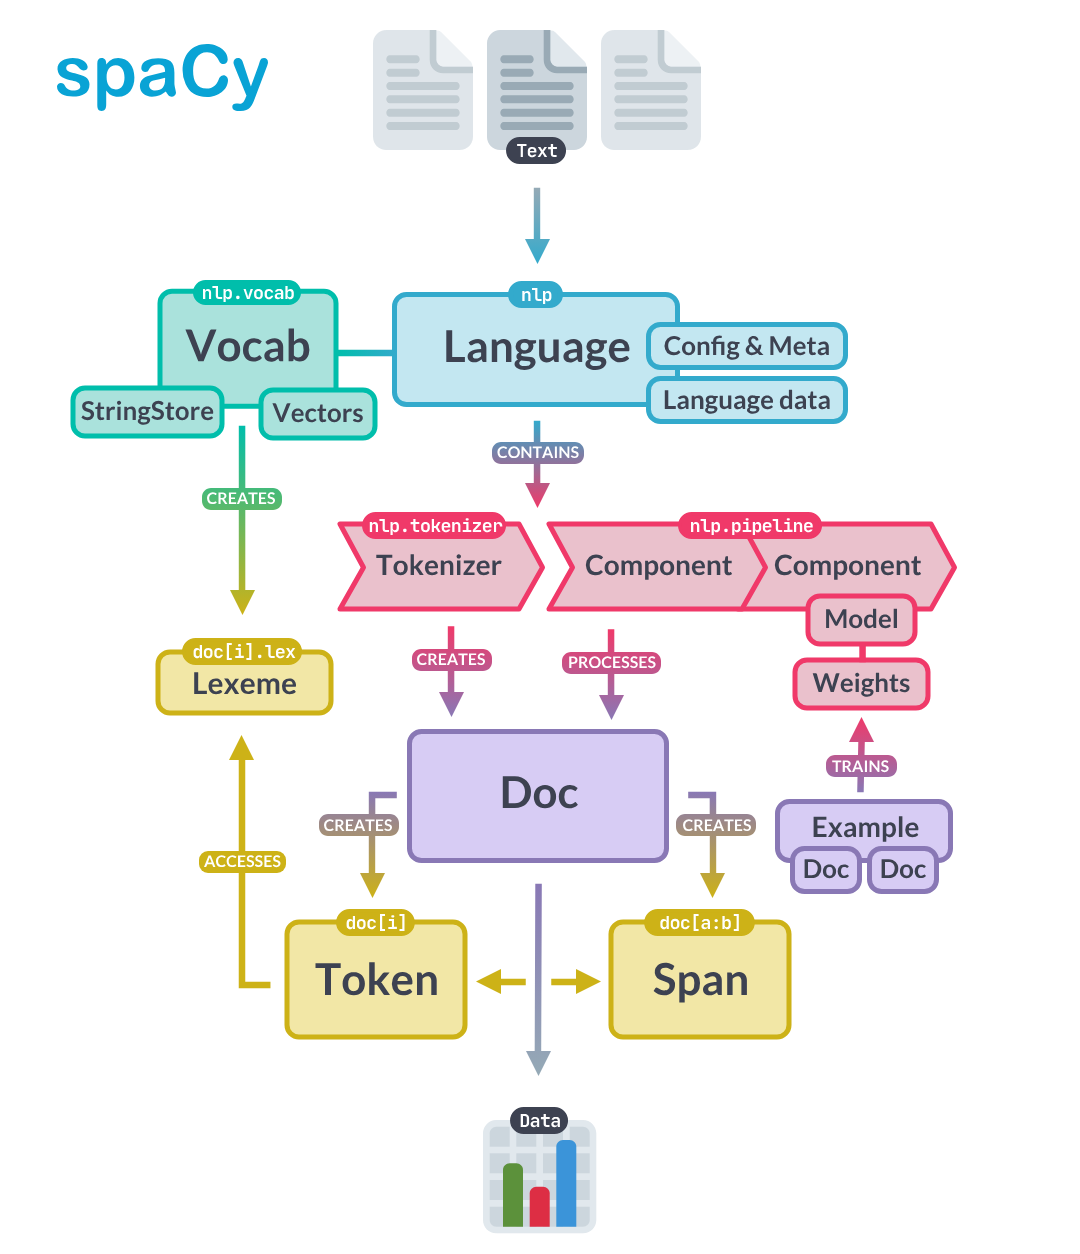











##**Language**:


### --main entry point in spaCy.


### --load a language model (en_core_web_sm, etc...)


### --Config & Meta ( about the pipeline and language-specific data)


### --Pretrained vocabulary, tokenization rules, and more.


##**Vocab**:

### --The vocabulary is shared across the pipeline.

### --StringStore (mapping of strings to unique IDs)

### --Vectors ( Pretrained word embeddings for semantic similarity)

### --creates Lexeme objects, which are entries in the vocabulary. A Lexeme is a context-independent word representation.


##**Tokenizer**:

### --Tokenizes raw text into individual Token objects.
### --Each token corresponds to a word, punctuation, or symbol in the input text.


##**Pipeline Components**:

### --A series of Components (ner/parser/tagger) process the Doc object created by the tokenizer.
### --Components use pretrained Models and Weights to process the text.


##**Doc**:

### --The core data structure in spaCy.
### --Represents the processed text with access to tokens, spans, and annotations.
### --Created by the tokenizer and processed further by pipeline components.


##**Token and Span**:

### --Token: Represents a single word, punctuation, or symbol in the text.
### --Span: Represents a slice of the Doc, which can include one or more tokens.

In [ ]:
!pip install 'portalocker>=2.0.0'

# multi30k dataset

## focuses on translating captions of images between languages

## 30,000 parallel sentences in the training set

## useful for small-medium machine translation tasks

In [ ]:
!pip install --upgrade torchdata==0.6.1

  Using cached torchdata-0.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached torchdata-0.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0


# **STEP-1 : import Library**



## get_tokenizer

### -- use for S2W ( sentence to words , subwords ....)

### -- build_vocal_from_iterator ( build vocab / map unique integer)

### -- pad_sequence specially used for make a same length of sentence all ( menas if you have 2 sentences one have 4 words and another have 2 words so second sentence make equal with max of all means first use 0 pad


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

In [ ]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)
print(device)

cuda:0



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

# **STEP-2: Import Dataset**

In [ ]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

## en_core_web_sm  -- download english language model for spacy

## de_core_news_sm -- download German language model for spacy


In [ ]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

  Using cached torchdata-0.11.0-py3-none-any.whl.metadata (6.3 kB)
Using cached torchdata-0.11.0-py3-none-any.whl (61 kB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.6.1
    Uninstalling torchdata-0.6.1:
      Successfully uninstalled torchdata-0.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.2 requires torchdata==0.6.1, but you have torchdata 0.11.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 95.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **STEP:3 - Tokenization**

## tokens for either the german sentence or english sentence

In [ ]:
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    if language=='de':
        for data_sample in data_iter:
            yield de_tokenizer(data_sample[0])
    elif language=='en':
        for data_sample in data_iter:
            yield en_tokenizer(data_sample[1])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
vocab_de=build_vocab_from_iterator(yield_tokens(train_iter, 'de'),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
vocab_de.set_default_index(UNK_IDX)
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
vocab_en=build_vocab_from_iterator(yield_tokens(train_iter, 'en'),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
vocab_en.set_default_index(UNK_IDX)

In [ ]:
print(type(vocab_en))
print("English Vocab Length:",vocab_en.__len__())
print("German Vocab Length:",vocab_de.__len__())

<class 'torchtext.vocab.vocab.Vocab'>
English Vocab Length: 10837
German Vocab Length: 19214


#**STEP:4 - PROCESS**

## prepares source / target senteces IDs for batching.

## src_batch / tgt_batch = [] means convert tensor ( it like 1D array like numpy )

## after that removes trailing newline characters from sentences

## now splits the sentences into lists of tokens ( words / subwords )

## then provide each token to IDs

## also add special tokens

## then convert this IDs into tensors for processing

## then appends tensor to batch list

## and then return batches

In [ ]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:

        src_sample=src_sample.rstrip("\n")
        tgt_sample=tgt_sample.rstrip("\n")

        src_tokens=de_tokenizer(src_sample)
        tgt_tokens=en_tokenizer(tgt_sample)

        src_ids=vocab_de(src_tokens)
        tgt_ids=vocab_en(tgt_tokens)

        src_ids.append(EOS_IDX)
        tgt_ids.append(EOS_IDX)

        tgt_ids.insert(0,BOS_IDX)

        src_tensor=torch.tensor(src_ids)
        tgt_tensor=torch.tensor(tgt_ids)


        src_batch.append(src_tensor)
        tgt_batch.append(tgt_tensor)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True) #returns tensor
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

#**STEP:5 - Define Encoder**

## input_size -- size of the vocab ( with unique token )

## embed_size -- size of vector used to represent each words.

## nn.Embedding -- converts word idx to dense embedding vectors of size embed_size.

## nn.GRU -- processes the sequence of embeddings and generates hidden states







In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, dropout_p=0.1):
        super().__init__()
        self.e=nn.Embedding(input_size, embed_size)
        self.dropout=nn.Dropout(dropout_p)
        self.gru=nn.GRU(embed_size,hidden_size, batch_first=True)

    def forward(self,x):
        x=self.e(x)
        x=self.dropout(x)
        outputs, hidden=self.gru(x)
        return outputs, hidden

# **STEP:6 - Define Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(self,output_size,embed_size,hidden_size):
        super().__init__()
        self.e=nn.Embedding(output_size,embed_size)
        self.relu=nn.ReLU()
        self.gru=nn.GRU(embed_size, hidden_size, batch_first=True)
        self.lin=nn.Linear(hidden_size,output_size)
        self.lsoftmax=nn.LogSoftmax(dim=-1) # last dimension of the tensor

    def forward(self,x,prev_hidden):
        x=self.e(x)
        x=self.relu(x)
        output,hidden=self.gru(x,prev_hidden)
        y=self.lin(output)
        y=self.lsoftmax(y)
        return y, hidden

# **STEP:7 - Train Model**

In [ ]:
def train_one_epoch():
    encoder.train()
    decoder.train()
    track_loss=0

    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=batch_size, collate_fn=collate_fn)

    for i, (s_ids,t_ids) in enumerate(train_dataloader):

        s_ids=s_ids.to(device)
        t_ids=t_ids.to(device)

        encoder_outputs, encoder_hidden=encoder(s_ids)
        decoder_hidden=encoder_hidden

        yhats, decoder_hidden = decoder(t_ids[:,0:-1],decoder_hidden)

        gt=t_ids[:,1:]

        yhats_reshaped=yhats.view(-1,yhats.shape[-1])

        gt=gt.reshape(-1)


        loss=loss_fn(yhats_reshaped,gt)
        track_loss+=loss.item()

        opte.zero_grad()
        optd.zero_grad()

        loss.backward()

        opte.step()
        optd.step()

    return track_loss/(i+1)

In [ ]:
def eval_one_epoch(e,n_epochs):
    encoder.eval()
    decoder.eval()
    track_loss=0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=1, collate_fn=collate_fn)

    with torch.no_grad():
        for i, (s_ids,t_ids) in enumerate(val_dataloader):
            s_ids=s_ids.to(device) # [1, source sequence length]
            t_ids=t_ids.to(device)
            encoder_outputs, encoder_hidden=encoder(s_ids)
            decoder_hidden=encoder_hidden #n_dim=3
            input_id=t_ids[:,0] #shape is just [1]
            yhats=[]
            if e+1==n_epochs:
                pred_sentence=""
            for j in range(1,t_ids.shape[1]): #j starts from 1 #iterates for len(t_ids)-1 times as the last id is of <EOS>
                probs, decoder_hidden = decoder(input_id.unsqueeze(1),decoder_hidden) #need batch_size x seq_length
                yhats.append(probs)
                _,input_id=torch.topk(probs,1,dim=-1)
                input_id=input_id.squeeze(1,2) #still a tensor
                if e+1==n_epochs:
                    word=vocab_en.lookup_token(input_id.item()) #batch_size=1
                    pred_sentence+=word + " "
                if input_id.item() == 3: #batch_size=1 #Id 3 is <EOS>
                    break

            if e+1==n_epochs:
                src_sentence_tokens=vocab_de.lookup_tokens(s_ids.tolist()[0])
                src_sentence=" ".join(src_sentence_tokens)
                gt_sentence_tokens=vocab_en.lookup_tokens(t_ids[:,1:].tolist()[0])
                gt_sentence=" ".join(gt_sentence_tokens)
                print("\n-----------------------------------")
                print("Source Sentence:",src_sentence)
                print("GT Sentence:",gt_sentence)
                print("Predicted Sentence:",pred_sentence)

            yhats_cat=torch.cat(yhats,dim=1)
            yhats_reshaped=yhats_cat.view(-1,yhats_cat.shape[-1])
            gt=t_ids[:,1:j+1] #shape is [1, target sequence length -1] #as <BOS> is not part of GT

            gt=gt.view(-1) #shape is [target sequence length -1]

            loss=loss_fn(yhats_reshaped,gt)
            track_loss+=loss.item()

        if e+1==n_epochs:
            print("-----------------------------------")
        return track_loss/(i+1)

In [ ]:
embed_size=300
hidden_size=512
batch_size=32

encoder=Encoder(vocab_de.__len__(),embed_size,hidden_size).to(device) #translation-direction sensitive
decoder=Decoder(vocab_en.__len__(),embed_size,hidden_size).to(device) #translation-direction sensitive

loss_fn=nn.NLLLoss(ignore_index=1).to(device)
lr=0.001
opte=optim.Adam(params=encoder.parameters(), lr=lr, weight_decay=0.001)
optd=optim.Adam(params=decoder.parameters(), lr=lr, weight_decay=0.001)

n_epochs=20

for e in range(n_epochs):
    print("Epoch=",e+1, sep="", end=", ")
    print("Train Loss=", round(train_one_epoch(),4), sep="", end=", ")
    print("Eval Loss=",round(eval_one_epoch(e,n_epochs),4), sep="")

Streaming output truncated to the last 5000 lines.
Source Sentence: Drei Menschen auf zwei Geländemotorrädern und einem Quad fahren durch braunes Gras . <eos>
GT Sentence: Three people on two dirt - bikes and one four - wheeler are riding through brown grass . <eos>
Predicted Sentence: Three people are walking down a beach with a small dog . <eos> 

-----------------------------------
Source Sentence: Ein <unk> Mann schläft draußen auf seinem Stuhl . <eos>
GT Sentence: A half naked man is sleeping on his chair outdoors . <eos>
Predicted Sentence: A man sitting on the street . <eos> 

-----------------------------------
Source Sentence: Eine Gruppe von Menschen steht vor einer <unk> auf einem Parkplatz . <eos>
GT Sentence: A group of people standing in front of a hut in a parking lot . <eos>
Predicted Sentence: A group of people in a blue jacket . <eos> 

-----------------------------------
Source Sentence: Eine junge Frau fertigt im <unk> Teppiche an <eos>
GT Sentence: A young woman is